<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/nn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
!git clone https://github.com/pharringtonp19/business-analytics.git

fatal: destination path 'business-analytics' already exists and is not an empty directory.


### **Import Libraries**

In [203]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
import math
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import partial

### **Configuration**

In [204]:
din = 1
dmid = 64
dout = 1
init_int = 0

### **Read In Data**

In [205]:
df = pd.read_csv('/content/business-analytics/datasets/AirPassengers.csv')
df.columns = ['Month', 'Passengers']
# Convert 'Month' to datetime if not already
df['Month_numeric'] = pd.to_datetime(df['Month'])
# Calculate the number of months since the first date
df['Month_Encoded'] = (df['Month_numeric'] - df['Month_numeric'].min()).dt.days // 30
# Min-Max Scaling
m1, std1 = df['Month_Encoded'].mean(), df['Month_Encoded'].std()
df['Month_Encoded_Scaled'] = (df['Month_Encoded'] - m1) / std1

m2, std2 = df['Passengers'].mean(), df['Passengers'].std()
df['Standardized_Passengers'] = (df['Passengers'] - m2) / std2
df.head()

,Month,Passengers,Month_numeric,Month_Encoded,Month_Encoded_Scaled,Standardized_Passengers
0,1949-01,112,1949-01-01,0,-1.706406,-1.402882
1,1949-02,118,1949-02-01,1,-1.682720,-1.352868
2,1949-03,132,1949-03-01,1,-1.682720,-1.236169
3,1949-04,129,1949-04-01,3,-1.635347,-1.261176
4,1949-05,121,1949-05-01,4,-1.611661,-1.327861


### **Define Model**

In [206]:
class Model(nnx.Module):
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear3 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear4 = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x):
    x1 = nnx.gelu(self.linear1(x))
    x2 = nnx.gelu(self.linear2(x1))
    x3 = nnx.gelu(self.linear3(x2))
    return self.linear4(x3)

### **Initialize Model**

In [207]:
model = Model(din, dmid, dout, nnx.Rngs(init_int))
initial_params = params = nnx.state(model, nnx.Param)

### **Optimizer**

In [208]:
optimizer = nnx.Optimizer(model, optax.adam(1e-3))  # reference sharing
metrics = nnx.MultiMetric(loss=nnx.metrics.Average('loss'))

### **Initial Predictions**

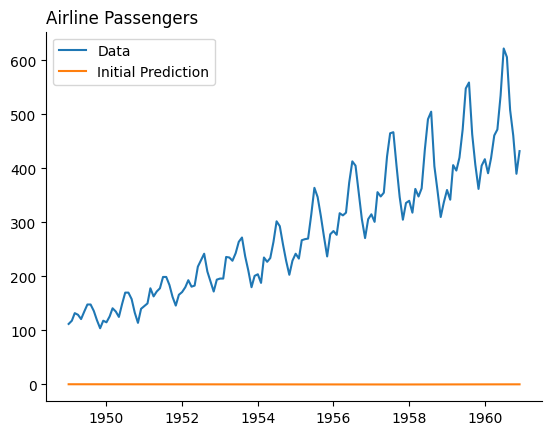

In [209]:
xs = jnp.array(df['Month_Encoded_Scaled'].values).reshape(-1,1)
ys = jnp.array(df['Standardized_Passengers'].values).reshape(-1,1)
y_hat_init = model(xs)
plt.plot(df['Month_numeric'], df['Passengers'], label='Data')
plt.plot(df['Month_numeric'], y_hat_init, label='Initial Prediction')
plt.legend()
plt.title('Airline Passengers', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### **Trainging Step**

In [210]:
@nnx.jit  # <== currently slow
def train_step(model, optimizer, metrics, x, y):
  def loss_fn(model):
    y_pred = model(x)  # call methods directly
    return ((y_pred - y) ** 2).mean()

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # in-place updates
  metrics.update(loss=loss)

  return loss

### **Full Training Run**

In [211]:
model = Model(din, dmid, dout, rngs=nnx.Rngs(init_int))
optimizer = nnx.Optimizer(model, optax.adam(1e-4))
loss_history = []
for _ in range(10000):
  loss = train_step(model, optimizer, metrics, xs, ys)
  loss_history.append(loss)

### **Plot Training Loss**

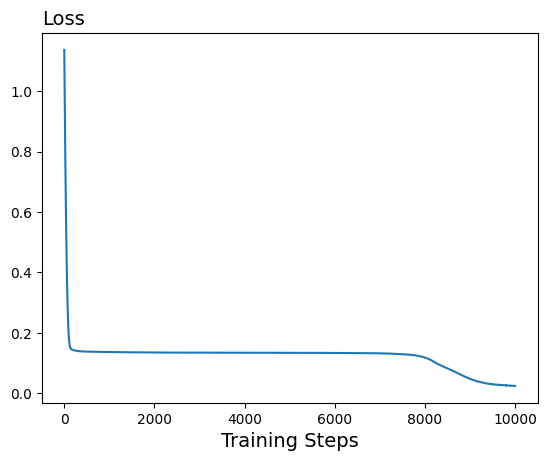

In [212]:
plt.plot(loss_history)
plt.xlabel('Training Steps', size=14)
plt.title('Loss', loc='left', size=14)
plt.show()

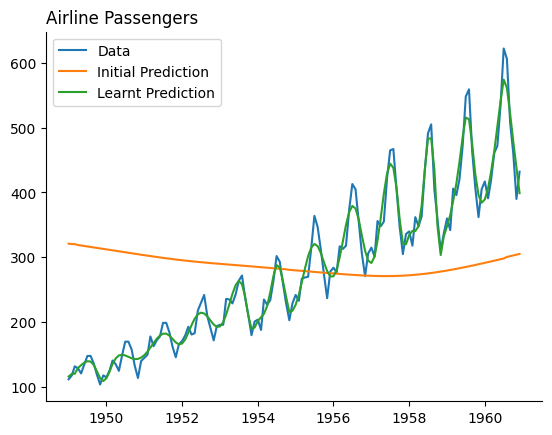

In [213]:
xs = jnp.array(df['Month_Encoded_Scaled'].values).reshape(-1,1)
y_hat_final = model(xs)
plt.plot(df['Month_numeric'], df['Passengers'], label='Data')
plt.plot(df['Month_numeric'], y_hat_init*std2 + m2, label='Initial Prediction')

plt.plot(df['Month_numeric'], y_hat_final*std2 + m2, label='Learnt Prediction')
plt.legend()
plt.title('Airline Passengers', loc='left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

### **Convex Combination**

In [214]:
def interpolate_params(params1, params2, alpha):
    return jax.tree.map(lambda p1, p2: (1 - alpha) * p1 + alpha * p2, params1, params2)

def interpolate_loss(params1, params2, alpha):
    # Interpolate parameters
    params = interpolate_params(params1, params2, alpha)

    graphdef = nnx.graphdef(model)
    # Create a new model instance with the interpolated parameters
    interpolated_model = nnx.merge(graphdef, params)

    # Call the model with inputs
    yhat = interpolated_model(xs)

    # Compute the mean squared error
    return jnp.mean((yhat - ys) ** 2)

learnt_params = params = nnx.state(model, nnx.Param)
alphas = jnp.linspace(0, 1, 100)
f = partial(interpolate_loss, initial_params, learnt_params)
ls = jax.vmap(f)(alphas)

### **Plot**

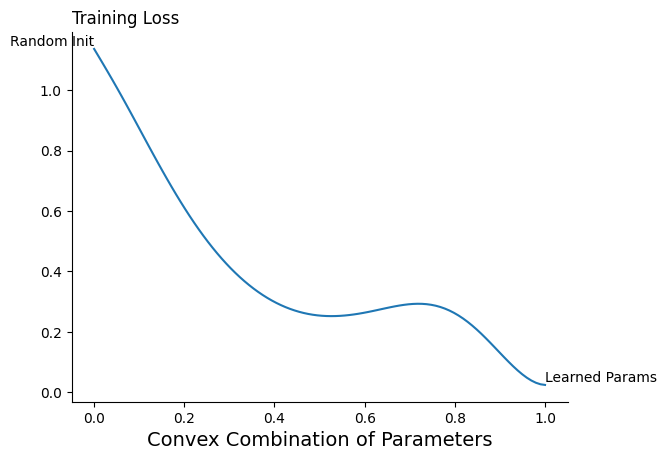

In [220]:
plt.plot(alphas, ls)
plt.title('Training Loss', loc='left')

# Label the x-axis to indicate the convex combination
plt.xlabel('Convex Combination of Parameters', size=14)

# Add annotations for 0.0 and 1.0
plt.text(0, ls[0], 'Random Init',
         verticalalignment='bottom',
         horizontalalignment='right')
plt.text(1, ls[-1], 'Learned Params',
         verticalalignment='bottom',
         horizontalalignment='left')

# Remove top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the plot
plt.show()